# Converting pyKasso network outputs to SWMM inputs #
**Authors:** Chloé Fandel 2022. <br>

Work session in Neuchâtel with Anthony & Philippe July 2022

### Setup & imports ###
For development, import a local version of pykasso be able to make and test changes.
Use one of the two methods below (but not both).


In [1]:
method = 2

#Method 1: using importlib
if method==1:
    import importlib.util
    spec = importlib.util.spec_from_file_location('pykasso', 'C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso/base.py')
    pk = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pk)

#Method 2: setting the path variable to the path to the local version 
#This version allows reloading the module to see changes
if method==2:
    import sys
    #sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
    sys.path.append('C:/Users/cfandel/GitHub/pyKasso/pykasso') #path to local version of package
    import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #uncomment this line to create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [143]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import copy
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann

#Local modules:
import_local_modules = True
if import_local_modules:
    import importlib.util
    #spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py') #use local path on your own computer
    spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/cfandel/GitHub/pyKasso/pykasso/swmmpy.py')
    sp = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(sp)

os.getcwd()

'C:\\Users\\cfandel\\GitHub\\pyKasso\\notebooks'

## Simple one-valley system ###
A simple synthetic system, consisting of a single outlet draining a valley. There are only three geologic units: highly karstifiable limestone folded into a syncline along the valley axis, underlain by non-karstifiable shale, with an obstacle in the form of a non-karstifiable granite intrusion. Five inlets are randomly distributed across the upper part of the valley. 

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


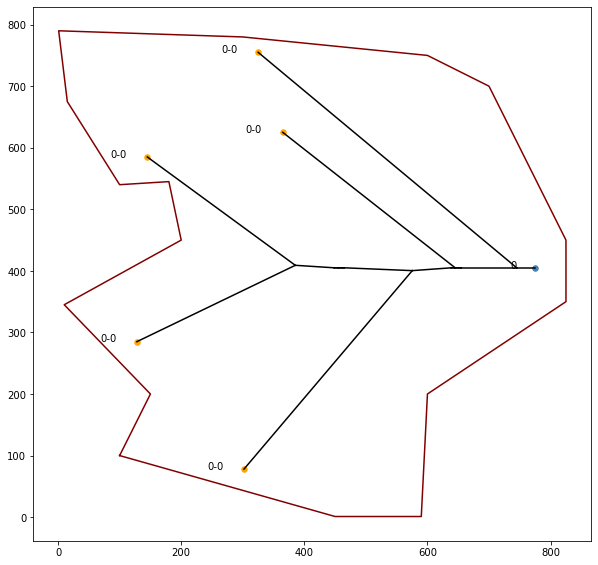

In [3]:
importlib.reload(pk)

#Load model:
catchment = pk.SKS('inputs/valley1/settings.yaml') 

#Modify model settings (uncomment to activate):
catchment.set_fractures_mode('null')                          #randomly generate a discrete fracture network
#catchment.set_outlets_data('inputs/valley1/outlets2D.txt')      #load a new outlet file with two outlets instead of one
#catchment.update_outlets()                                      #update
#catchment.set_outlets_importance([1,1])                         #assign one outlet to the first iteration and one to the second iteration
#catchment.set_inlets_per_outlet([2,3])                          #assign the first two inlets to the first outlet, and the remaining three inlets to the second outlet
#catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
catchment.set_data_has_polygon(True)                             #add a polygon bounding the area of interest
catchment.update_polygon()

catchment.set_orientation_mode('surface')                        #use the lower surface of the karst unit as the anisotropy field
catchment.update_orientation()                                   #update

#Run anisotropic conduit network simulation & display results:
catchment.set_algorithm('Riemann2')
catchment.compute_karst_network()
#catchment.show()
catchment.show_network(data=catchment.karst_simulations[0], simplify=True, labels=['inlets','outlets'], plot_nodes=False, legend=False, color='k')


### Tsanfleuron system ###
Testing with Tsanfleuron data - below here, need to replace all Gottesacker files with Tsanfleuron files


#### Load example ####

In [ ]:
importlib.reload(pk)

catchment = pk.SKS('inputs/tsanfleuron/settings.yaml') #import settings and options from input folder

catchment.set_algorithm('Riemann2')
catchment.set_inlets_data('inputs/tsanfleuron/inlets2D_simple.txt')
catchment.update_all()
catchment.compute_karst_network()
catchment.show()
catchment.show_network(simplify=True)

CAUTION: You are using the development version of this package.


In [133]:
def pk2swmm(catchment, dim=2, simplify=True, elev_file=None):
    
    '''Converts network info (nodes and links) from pyKasso to pandas dataframes compatible with swmmpy. 
    
    Inputs:
    catchment:   pykasso model object
    elev_file:   text file with one column, for elevation of each node (only if using a 2D network with elevations added after)
    dim:         number of dimensions pykasso ran in (2 or 3) 
                 (if pykasso output a 2D network, must add Z coordinates to all nodes from elevation file)
    simplify:    True/False, whether to simplify the SKS network or not (defaults to True)
    
    Outputs:
    nodesSWMM:   pandas df with all nodes, and columns: X, Y, Z, type, Name. Type is either 'junction', or 'outfall'
    linksSWMM:   pandas df with all links, and columns: InNode, OutNode, Name
    '''
       
    #Get nodes and edges from pykasso karst simulations:
    nodes = catchment.karst_simulations[0].network['nodes']
    edges = catchment.karst_simulations[0].network['edges']

    #Simplify
    if simplify==True:
        nodes_simple = catchment.karst_simulations[0].network['karstnet'].graph_simpl.nodes  #get indices of only the nodes in the simplified graph
        nodes_simple = {key: nodes[key] for key in nodes_simple}   #make df of only the nodes in the simplified graph, for plotting
        edges_simple = catchment.karst_simulations[0].network['karstnet'].graph_simpl.edges  #get only the edges in the simplified graph
        edges_simple = {i: edge for i,edge in enumerate(edges_simple)}   #make df of only the edges in the simplified graph, for p
        nodes = nodes_simple  #replace complex nodes object with simple nodes object
        edges = edges_simple  #replace complext edges object with simple edges object
        print('network simplified')
        
    #Convert to dataframe
    if dim == 2: 
        nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y','type']) #convert to pandas for easier plotting
        nodes.insert(2, 'Z', pd.read_csv(elev_file, header=None, names=['Z'])) #insert a column for Z value based on file
    if dim == 3:        
        nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y','Z','type']) #convert to pandas for easier plotting

    nodes['Name'] = nodes.index   #add a column at end for node name based on index
    nodes.reset_index(drop=True, inplace=True) #reset index to start counting from zero
    edges = pd.DataFrame.from_dict(edges, orient='index', columns=['In','Out'])

    #Replace InNode and OutNode names with re-indexed node names from simplified network:
    ins, outs = [],[]                                                #create empty lists to store info
    for i in range(len(edges)):                                      #loop over each link index
        edge = edges.iloc[i]                                         #get current link
        ins.append(nodes.loc[nodes.Name==link.In].index.values[0])       #get & store new simplified InNode index
        outs.append(nodes.loc[nodes.Name==link.Out].index.values[0])     #same for OutNode
    edges['InNode'] = ins                                            #add column with simplified InNode indices
    edges['OutNode'] = outs                                          #add column with simplified OutNode indices
    edges['Name'] = edges.index.values                #add name column with 0-based indices
    edges.drop(columns=['In','Out'], inplace=True)    #drop unneeded columns with original complex node indices
    nodes['Name'] = nodes.index.values                #add name column with 0-based indices
       
    return nodes, edges                               #return node and edge dataframes formatted for insertion into SWMM input file using swmmpy


In [137]:
nodesSWMM, linksSWMM = pk2swmm(catchment, dim=2, simplify=True, elev_file='inputs/tsanfleuron/nodesZ.txt')

network simplified


In [139]:
nodesSWMM

,X,Y,Z,type,Name
0,129295.000000,587320.000000,2400,inlet,0
1,129325.919340,587811.402309,2300,junction,1
2,129165.677909,588881.182022,2300,junction,2
3,128850.000000,583380.000000,2400,inlet,3
4,128650.000000,589650.000000,1500,outfall,4
5,130180.000000,588450.000000,2400,inlet,5
